In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [14]:
# df = pd.read_csv('p2p_selected_f1_rfe.csv')
# Y= df['loan_status']
# encoded = df.drop(['loan_status'], axis=1)

In [15]:
pip install lightgbm catboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [55]:

# Data Splitting
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# import xgboost as xgb  # Requires xgboost library
import lightgbm as lgb # Optional: If you want to add LightGBM
import catboost as cb # Optional: If you want to add CatBoost

# Metrics & Plotting
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score, # AUC-PR
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    brier_score_loss,
    RocCurveDisplay,         # For plotting ROC
    PrecisionRecallDisplay # For plotting PR
)
# --- Add KS Statistic import ---
from scipy.stats import ks_2samp

# --- 1. Prerequisites ---
# Assume these variables are already defined and loaded:
# encoded: Your full feature DataFrame BEFORE feature selection
# Y: Your target variable (Pandas Series or numpy array, 0s and 1s)
# selected_features_f1: List/Index of feature names selected by rfe_f1

print("--- Preparing Data ---")
X = encoded.copy()
print(f"Using {X.shape[1]} selected features.")


--- Preparing Data ---
Using 7 selected features.


In [56]:
# Read the CSV files
train_df = pd.read_csv('train_set.csv')
val_df = pd.read_csv('validation_set.csv')
test_df = pd.read_csv('test_set.csv')

# Split into X (features) and y (target) for each set
def split_features_target(df, target_col='loan_status'):
    X = df.drop(columns=[target_col])  # Features (all columns except target)
    y = df[target_col]                # Target (only the specified column)
    return X, y

# Apply splitting to each dataset
X_train, y_train = split_features_target(train_df)
X_val, y_val = split_features_target(val_df)
X_test, y_test = split_features_target(test_df)

# Verify shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (316359, 4) (316359,)
Validation set: (105453, 4) (105453,)
Test set: (105453, 4) (105453,)


In [57]:
# --- 2. Data Splitting (Train-Validation-Test) ---
# First split: Separate Test set (e.g., 20%)
# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     X, Y,
#     test_size=0.20,       # 20% for test set
#     random_state=42,      # For reproducibility
#     stratify=Y            # Essential for maintaining class distribution
# )

# # Second split: Separate Train and Validation sets from the remainder
# # Split 80% into 75% train (60% of total) and 25% validation (20% of total)
# val_size_relative = 0.25 # 0.20 / (1.0 - 0.20) = 0.25 -> 25% of the 80% gives 20% overall
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val, y_train_val,
#     test_size=val_size_relative,
#     random_state=42,      # Use same random state for consistency? Or different? Usually different is fine.
#     stratify=y_train_val   # Stratify again
# )

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train positive class %: {y_train.mean():.3f}")
print(f"Validation positive class %: {y_val.mean():.3f}")
print(f"Test positive class %: {y_test.mean():.3f}")




Train shape: (316359, 4), Validation shape: (105453, 4), Test shape: (105453, 4)
Train positive class %: 0.062
Validation positive class %: 0.062
Test positive class %: 0.062


In [58]:
# --- 3. Preprocessing: Scaling ---
# Scale features based ONLY on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames (optional, but preserves feature names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n--- Feature Scaling Applied ---")


# --- 4. Calculate `scale_pos_weight` for relevant models ---
# This is used to balance classes in algorithms that support it
neg_count, pos_count = y_train.value_counts().sort_index()
scale_pos_weight_value = neg_count / pos_count
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f} ({neg_count} neg / {pos_count} pos)")





--- Feature Scaling Applied ---
Calculated scale_pos_weight for XGBoost: 15.01 (296595 neg / 19764 pos)


In [59]:
# --- 5. Define Models ---
# Note: Hyperparameters are basic examples; tuning is recommended later!
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        solver='lbfgs',          # Supports penalty='none'
        penalty=None,          # *** REMOVE REGULARIZATION ***
        random_state=42,
        max_iter=2000,           # May need more iterations without penalty
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced',
        n_estimators=150,
        random_state=42,
        n_jobs=-1
        # No explicit L1/L2 regularization parameter here
    ),
   "LightGBM": lgb.LGBMClassifier(
        objective='binary',
        # Use is_unbalance=True for easy imbalance handling OR
        # scale_pos_weight=scale_pos_weight_value (choose one)
        is_unbalance=True,
        random_state=42,
        n_jobs=-1                # Use all available CPU cores
        # Add other LGBM params like n_estimators, learning_rate etc. if needed
    ),
    "CatBoost": cb.CatBoostClassifier(
        loss_function='Logloss', # Standard for binary classification
        # Use auto_class_weights='Balanced' OR
        # scale_pos_weight=scale_pos_weight_value (choose one)
        auto_class_weights='Balanced',
        random_state=42,
        thread_count=-1,         # Use all available CPU cores
        verbose=0                # Suppress excessive training output
        # Add other CatBoost params like iterations, learning_rate etc. if needed
    
    ),
    # "SVC": SVC(
    #     class_weight='balanced',
    #     probability=True,
    #     random_state=42
    #     # C=1.0 is default. Very large C approximates no regularization but risks overfitting.
    #     # Keeping default C=1.0 here as standard practice.
    # ),
    "MLP Classifier": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.0,              # *** REMOVE L2 REGULARIZATION ***
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
        random_state=42,
        max_iter=500
    )
}



In [60]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [61]:
from scipy.stats import ks_2samp


Plots will be saved in directory: 'model_evaluation_plots'

--- Training Logistic Regression ---
Training completed in 2.06 seconds
Evaluating Logistic Regression on Validation Set...
Saving model_evaluation_plots/confusion_matrix_Logistic Regression_validation.png...


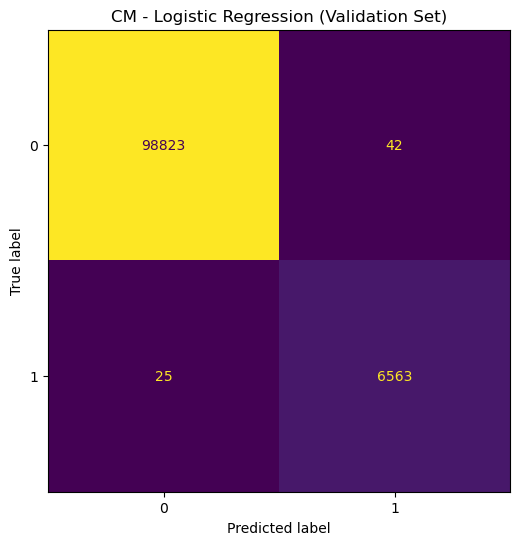

Evaluating Logistic Regression on Test Set...
Saving model_evaluation_plots/confusion_matrix_Logistic Regression_test.png...


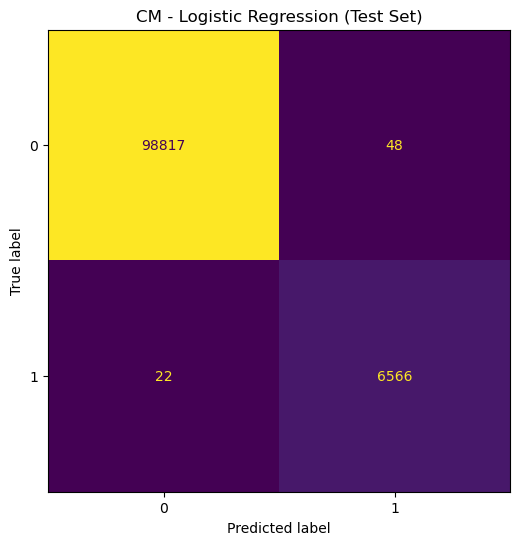


--- Training Random Forest ---
Training completed in 2.82 seconds
Evaluating Random Forest on Validation Set...
Saving model_evaluation_plots/confusion_matrix_Random Forest_validation.png...


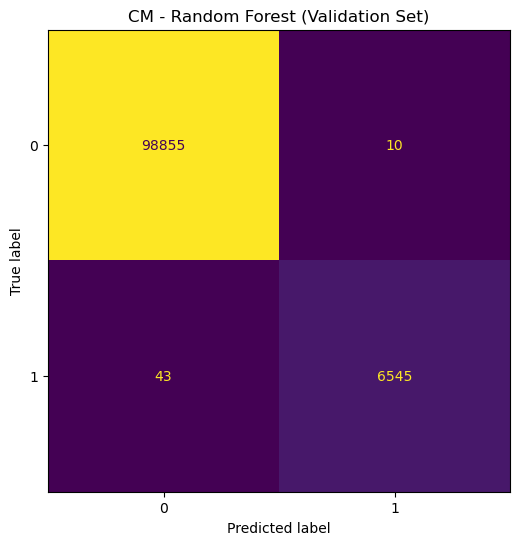

Evaluating Random Forest on Test Set...
Saving model_evaluation_plots/confusion_matrix_Random Forest_test.png...


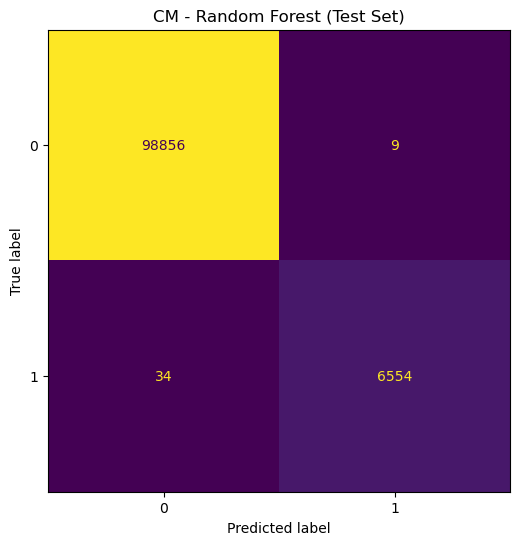


--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 19764, number of negative: 296595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 316359, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062473 -> initscore=-2.708505
[LightGBM] [Info] Start training from score -2.708505
Training completed in 0.43 seconds
Evaluating LightGBM on Validation Set...
Saving model_evaluation_plots/confusion_matrix_LightGBM_validation.png...


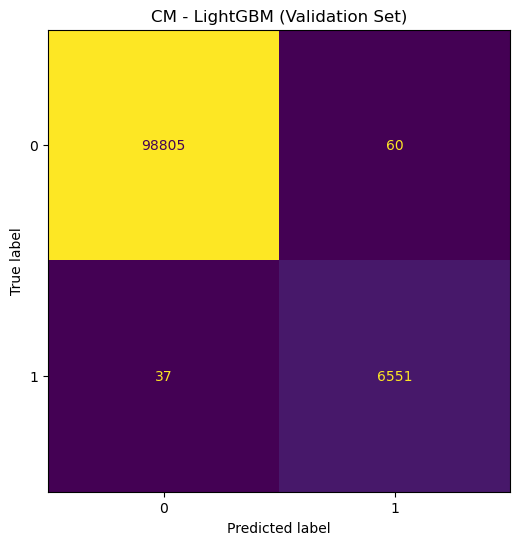

Evaluating LightGBM on Test Set...
Saving model_evaluation_plots/confusion_matrix_LightGBM_test.png...


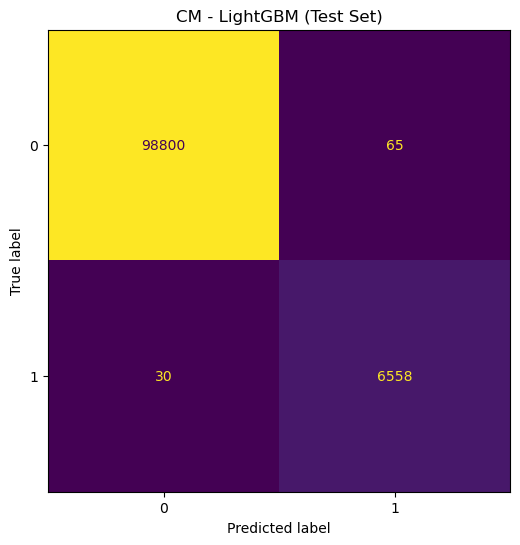


--- Training CatBoost ---
Training completed in 10.45 seconds
Evaluating CatBoost on Validation Set...
Saving model_evaluation_plots/confusion_matrix_CatBoost_validation.png...


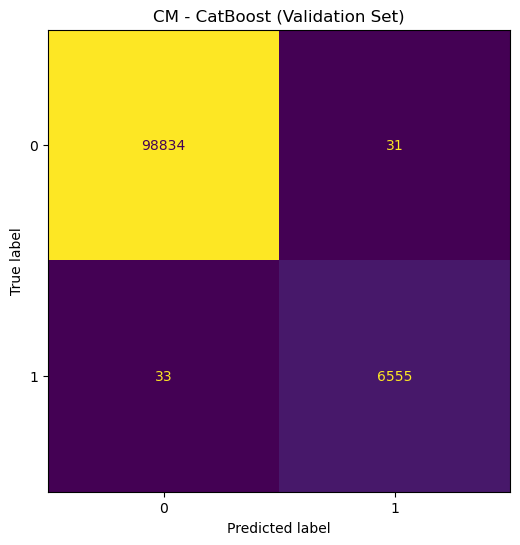

Evaluating CatBoost on Test Set...
Saving model_evaluation_plots/confusion_matrix_CatBoost_test.png...


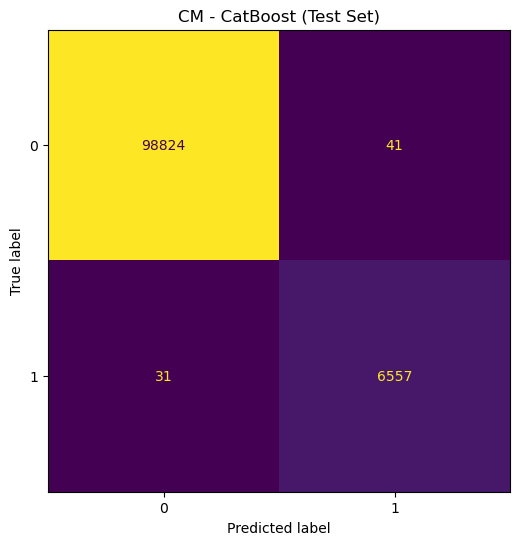


--- Training MLP Classifier ---
Training completed in 26.11 seconds
Evaluating MLP Classifier on Validation Set...
Saving model_evaluation_plots/confusion_matrix_MLP Classifier_validation.png...


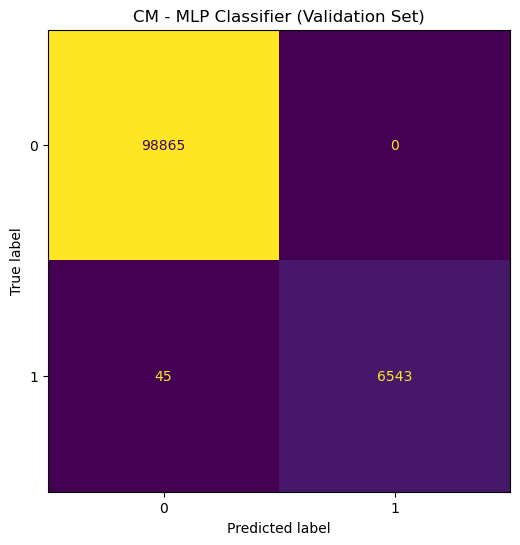

Evaluating MLP Classifier on Test Set...
Saving model_evaluation_plots/confusion_matrix_MLP Classifier_test.png...


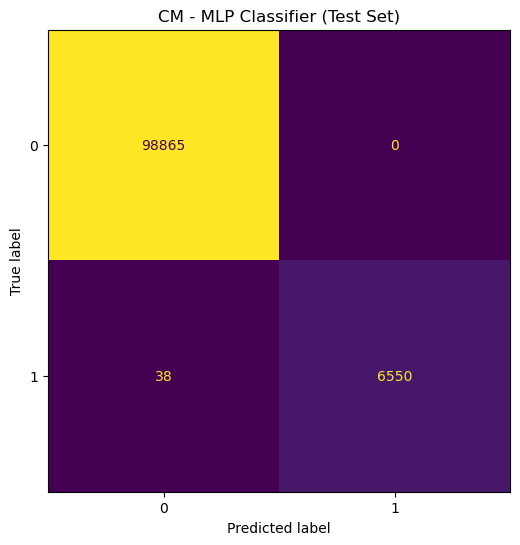

In [62]:
results_list = []
confusion_matrices = {"validation": {}, "test": {}}
trained_models = {} # Store trained models for later plotting

# --- Create directory for saving plots ---
plot_dir = "model_evaluation_plots"
os.makedirs(plot_dir, exist_ok=True)
print(f"\nPlots will be saved in directory: '{plot_dir}'")
# ---

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    trained_models[name] = model # Store the trained model

    # --- Loop through Validation and Test sets for evaluation ---
    for set_name, X_set, y_set in [("Validation", X_val_scaled, y_val), ("Test", X_test_scaled, y_test)]:
        print(f"Evaluating {name} on {set_name} Set...")
        y_pred = model.predict(X_set)
        y_proba = None
        ks_stat = None
        has_proba = False

        # Get probabilities and calculate KS if possible
        try:
            y_proba = model.predict_proba(X_set)[:, 1] # Probability of positive class
            has_proba = True
            proba_pos = y_proba[y_set == 1]
            proba_neg = y_proba[y_set == 0]
            if len(proba_pos) > 0 and len(proba_neg) > 0:
                 ks_stat, _ = ks_2samp(proba_pos, proba_neg)
            else:
                 print(f"Warning: Could not calculate KS for {name} on {set_name} set due to missing class samples.")
                 ks_stat = np.nan
        except AttributeError:
            print(f"Warning: {name} does not support predict_proba(). AUC/AUC-PR/Brier/KS cannot be calculated.")
            y_proba = np.zeros_like(y_set)
            ks_stat = np.nan

        # Calculate other metrics
        metrics = {
            "Model": name,
            "Set": set_name,
            "Fit Time (s)": train_time,
            "Accuracy": accuracy_score(y_set, y_pred),
            "F1 (Positive)": f1_score(y_set, y_pred, pos_label=1),
            "Recall (Positive)": recall_score(y_set, y_pred, pos_label=1),
            "Precision (Positive)": precision_score(y_set, y_pred, pos_label=1),
            "AUC-ROC": roc_auc_score(y_set, y_proba) if has_proba else np.nan,
            "AUC-PR": average_precision_score(y_set, y_proba) if has_proba else np.nan,
            "KS Stat": ks_stat, # Add KS statistic
            "Brier Score": brier_score_loss(y_set, y_proba) if has_proba else np.nan,
        }
        results_list.append(metrics)

        # Store and Plot Confusion Matrix
        cm = confusion_matrix(y_set, y_pred)
        confusion_matrices[set_name.lower()][name] = cm
        try:
             disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
             fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
             disp.plot(ax=ax_cm, cmap='viridis', colorbar=False)
             ax_cm.set_title(f"CM - {name} ({set_name} Set)")
             cm_filename = os.path.join(plot_dir, f"confusion_matrix_{name}_{set_name.lower()}.png")
             print(f"Saving {cm_filename}...")
             fig_cm.savefig(cm_filename, dpi=300, bbox_inches='tight')
             # plt.close(fig_cm) # REMOVED
             plt.show() # Explicitly show plot if desired after saving
        except Exception as e:
             print(f"Error plotting/saving confusion matrix for {name} ({set_name}): {e}")


In [63]:
# --- 7. Consolidate and Display Results ---
results_df = pd.DataFrame(results_list)

# Separate Validation and Test results for clarity
results_val_df = results_df[results_df["Set"] == "Validation"].set_index("Model").drop(columns="Set")
results_test_df = results_df[results_df["Set"] == "Test"].set_index("Model").drop(columns="Set")

print("\n\n--- Validation Set Results ---")
print(results_val_df.round(4)) # Round for display

print("\n\n--- Test Set Results ---")
print(results_test_df.round(4)) # Round for display

# --- Save Results DataFrames to CSV ---
results_val_filename = os.path.join(plot_dir, "validation_metrics.csv")
results_test_filename = os.path.join(plot_dir, "test_metrics.csv")
print(f"\nSaving validation metrics to: {results_val_filename}")
results_val_df.round(4).to_csv(results_val_filename)
print(f"Saving test metrics to: {results_test_filename}")
results_test_df.round(4).to_csv(results_test_filename)





--- Validation Set Results ---
                     Fit Time (s)  Accuracy  F1 (Positive)  Recall (Positive)  \
Model                                                                           
Logistic Regression        2.0582    0.9994         0.9949             0.9962   
Random Forest              2.8158    0.9995         0.9960             0.9935   
LightGBM                   0.4322    0.9991         0.9927             0.9944   
CatBoost                  10.4508    0.9994         0.9951             0.9950   
MLP Classifier            26.1051    0.9996         0.9966             0.9932   

                     Precision (Positive)  AUC-ROC  AUC-PR  KS Stat  \
Model                                                                 
Logistic Regression                0.9936   0.9997  0.9990   0.9967   
Random Forest                      0.9985   0.9984  0.9977   0.9954   
LightGBM                           0.9909   0.9989  0.9980   0.9943   
CatBoost                           0.9953   


--- Generating Combined Metric Comparison Plots ---
Saving model_evaluation_plots/grouped_metrics_comparison_validation.png...


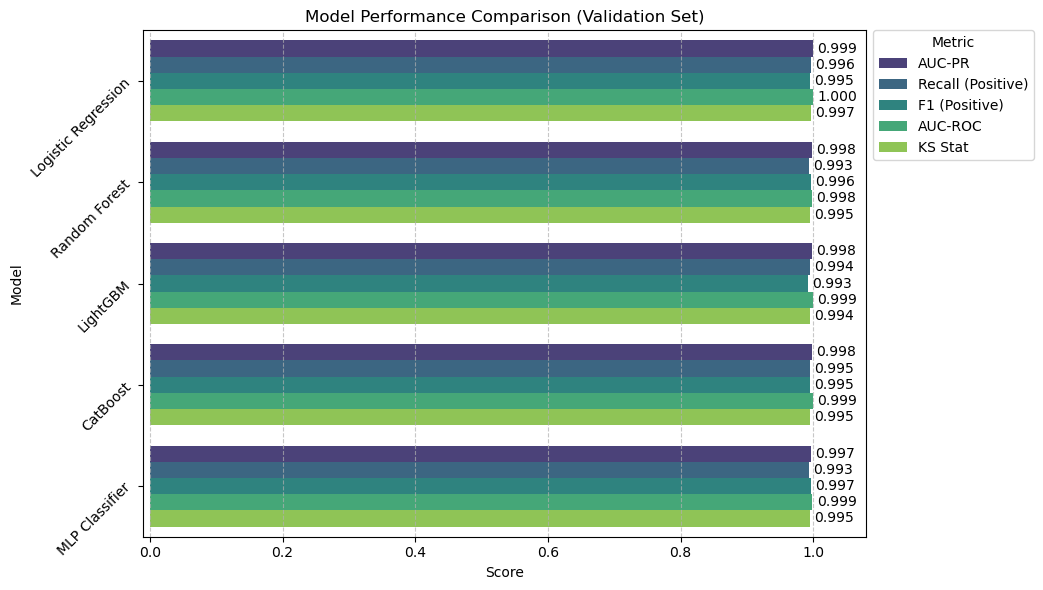

Saving model_evaluation_plots/grouped_metrics_comparison_test.png...


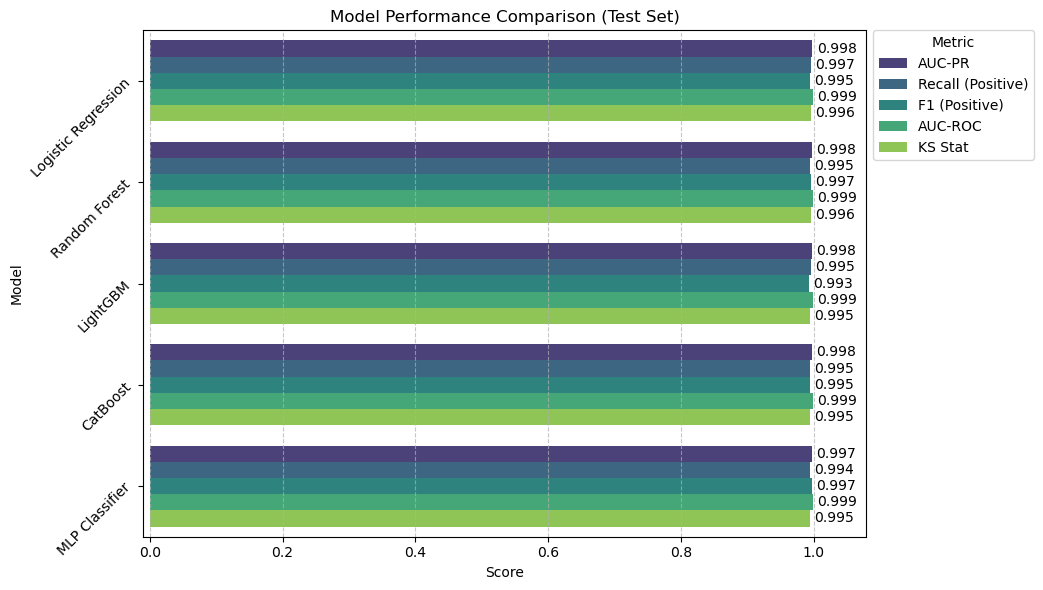


--- Generating ROC and PR Curve Plots (Test Set) ---
Saving model_evaluation_plots/roc_curves_comparison_test.png...


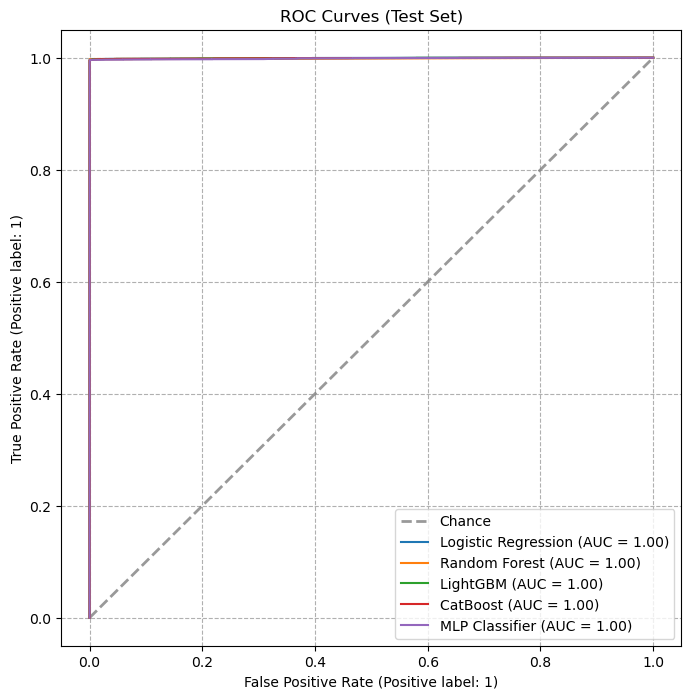

Saving model_evaluation_plots/pr_curves_comparison_test.png...


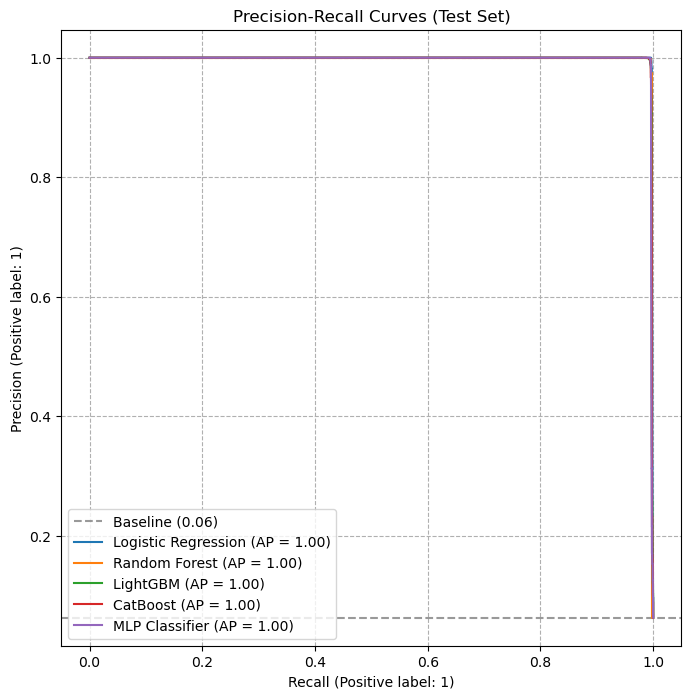


--- Evaluation Complete ---


In [64]:
metrics_to_plot = ["AUC-PR", "Recall (Positive)", "F1 (Positive)", "AUC-ROC", "KS Stat"]
print("\n--- Generating Combined Metric Comparison Plots ---")

for df, set_name in [(results_val_df, "Validation"), (results_test_df, "Test")]:
    try:
        # Prepare data: Reset index and melt
        df_reset = df.reset_index()
        # Keep only the metrics we want to plot, handle potential missing columns gracefully
        plot_cols = [metric for metric in metrics_to_plot if metric in df_reset.columns]
        if not plot_cols:
            print(f"No metrics to plot found in {set_name} results.")
            continue

        df_melted = pd.melt(df_reset,
                          id_vars='Model',
                          value_vars=plot_cols,
                          var_name='Metric',
                          value_name='Score').dropna(subset=['Score']) # Drop rows where score is NaN


        # Plotting
        num_models = df_reset['Model'].nunique()
        plot_height = max(6, num_models * 0.7) # Slightly increased height for rotated labels
        fig_grouped, ax_grouped = plt.subplots(figsize=(12, plot_height))

        # Create the grouped bar plot
        sns.barplot(data=df_melted, x='Score', y='Model', hue='Metric',
                    palette='viridis', # Or another suitable palette
                    orient='h',       # Horizontal bars
                    ax=ax_grouped)

        ax_grouped.set_title(f'Model Performance Comparison ({set_name} Set)')
        ax_grouped.set_xlabel('Score')
        ax_grouped.set_ylabel('Model')
        ax_grouped.grid(axis='x', linestyle='--', alpha=0.7) # Grid lines for x-axis

        # --- Rotate Y-axis labels ---
        ax_grouped.tick_params(axis='y', rotation=45)
        # --- End Rotation ---

        # --- Add value labels with padding ---
        for container in ax_grouped.containers:
            # Padding=3 reduces space vs default 5
            ax_grouped.bar_label(container, fmt='%.3f', label_type='edge', padding=3)
        # --- End Add value labels ---

        # --- Adjust X-axis limits with REDUCED padding ---
        # Find max score value actually plotted
        max_score_on_plot = df_melted['Score'].max() if not df_melted.empty else 1.0
        # Calculate padding based on max score *plotted* + a small buffer
        # Reduce the multiplier from 0.15 to 0.08 for less padding
        padding_factor = 0.08
        # Make sure padding accounts for label width, estimate based on typical label length
        label_width_estimate = 0.05 # Assumes labels are roughly 0.05 score units wide
        padding = max(max_score_on_plot * padding_factor, label_width_estimate)

        # Determine right limit
        new_xlim_right = max_score_on_plot + padding
        # Ensure limit is slightly > 1.0 if scores reach 1.0
        if max_score_on_plot >= 0.99:
            new_xlim_right = max(1.02, new_xlim_right)
        # Ensure limit isn't excessively large beyond 1.0 otherwise
        new_xlim_right = min(new_xlim_right, 1.1)

        ax_grouped.set_xlim(left=-0.01, right=new_xlim_right) # Start slightly left of 0 for visual separation
        # --- End Adjust X-axis limits ---

        # Adjust legend position (slightly adjusted margin)
        ax_grouped.legend(title='Metric', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

        # Adjust layout carefully for rotated labels and legend
        # rect=[left, bottom, right, top]
        fig_grouped.tight_layout(rect=[0, 0, 0.88, 1]) # Adjust right margin to leave space for legend

        # Save the figure
        grouped_filename = os.path.join(plot_dir, f"grouped_metrics_comparison_{set_name.lower()}.png")
        print(f"Saving {grouped_filename}...")
        fig_grouped.savefig(grouped_filename, dpi=300, bbox_inches='tight')
        plt.show() # Show plot

    except Exception as e:
        print(f"Error creating grouped bar plot for {set_name} set: {e}")



# --- Combined ROC and PR Curves (Test Set) ---
# --- (This section remains the same, saving and showing plots) ---
print("\n--- Generating ROC and PR Curve Plots (Test Set) ---")
# ROC Curve
try:
    fig_roc, ax_roc = plt.subplots(figsize=(8, 8))
    ax_roc.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
    for name, model in trained_models.items():
        try:
            RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, name=name, ax=ax_roc)
        except AttributeError: print(f"Skipping ROC plot for {name} (no predict_proba)")
        except Exception as e: print(f"Error generating ROC curve for {name}: {e}")
    ax_roc.set_title('ROC Curves (Test Set)')
    ax_roc.grid(linestyle='--')
    ax_roc.legend(loc='lower right')
    roc_filename = os.path.join(plot_dir, "roc_curves_comparison_test.png")
    print(f"Saving {roc_filename}...")
    fig_roc.savefig(roc_filename, dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e: print(f"Error creating ROC plot figure: {e}")

# Precision-Recall Curve
try:
    fig_pr, ax_pr = plt.subplots(figsize=(8, 8))
    pos_ratio_test = y_test.mean()
    ax_pr.axhline(pos_ratio_test, linestyle='--', color='grey', label=f'Baseline ({pos_ratio_test:.2f})', alpha=.8)
    for name, model in trained_models.items():
         try: PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test, name=name, ax=ax_pr)
         except AttributeError: print(f"Skipping PR plot for {name} (no predict_proba)")
         except Exception as e: print(f"Error generating PR curve for {name}: {e}")
    ax_pr.set_title('Precision-Recall Curves (Test Set)')
    ax_pr.grid(linestyle='--')
    ax_pr.legend(loc='lower left')
    pr_filename = os.path.join(plot_dir, "pr_curves_comparison_test.png")
    print(f"Saving {pr_filename}...")
    fig_pr.savefig(pr_filename, dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e: print(f"Error creating PR plot figure: {e}")

print("\n--- Evaluation Complete ---")

In [65]:
# --- 8. Notes and Next Steps ---
print("\n\n--- Notes ---")
print("*   Models trained on scaled data.")
print("*   Imbalance handled via 'class_weight' or 'scale_pos_weight' where applicable.")
print("*   MLPClassifier did not use explicit class weighting in this run.")
print("*   Hyperparameters used are basic examples; tuning is recommended.")
print("*   Focus on AUC-PR, Recall (Positive), F1 (Positive) for model comparison due to imbalance.")
print("\n--- Next Steps ---")
print("1.  Visualize results (e.g., bar plots for key metrics like AUC-PR, Recall).")
print("2.  Plot ROC and Precision-Recall curves for top models.")
print("3.  Perform hyperparameter tuning (e.g., GridSearchCV, RandomizedSearchCV) on the best performing model types using AUC-PR or F1 as the scoring metric.")
print("4.  Investigate MLP performance further, potentially using imblearn for resampling if needed.")
print("5.  Analyze feature importances from the final chosen model.")



--- Notes ---
*   Models trained on scaled data.
*   Imbalance handled via 'class_weight' or 'scale_pos_weight' where applicable.
*   MLPClassifier did not use explicit class weighting in this run.
*   Hyperparameters used are basic examples; tuning is recommended.
*   Focus on AUC-PR, Recall (Positive), F1 (Positive) for model comparison due to imbalance.

--- Next Steps ---
1.  Visualize results (e.g., bar plots for key metrics like AUC-PR, Recall).
2.  Plot ROC and Precision-Recall curves for top models.
3.  Perform hyperparameter tuning (e.g., GridSearchCV, RandomizedSearchCV) on the best performing model types using AUC-PR or F1 as the scoring metric.
4.  Investigate MLP performance further, potentially using imblearn for resampling if needed.
5.  Analyze feature importances from the final chosen model.


In [66]:
results_test_df.head()

,Fit Time (s),Accuracy,F1 (Positive),Recall (Positive),Precision (Positive),AUC-ROC,AUC-PR,KS Stat,Brier Score
Model,,,,,,,,,
Logistic Regression,2.058179,0.999336,0.994698,0.996661,0.992743,0.999401,0.998406,0.996398,0.000550
Random Forest,2.815847,0.999592,0.996730,0.994839,0.998629,0.998861,0.998104,0.995953,0.000393
LightGBM,0.432184,0.999099,0.992809,0.995446,0.990186,0.999138,0.997843,0.994910,0.000737
CatBoost,10.450776,0.999317,0.994540,0.995294,0.993786,0.999069,0.997709,0.994890,0.000637
MLP Classifier,26.105060,0.999640,0.997108,0.994232,1.000000,0.998724,0.997161,0.994971,0.000355


In [69]:
# --- Add joblib import ---
import joblib
import pandas as pd
import numpy as np
import os
# Assume previous code has run and these variables exist:
# trained_models: Dictionary {'Model Name': fitted_model_object, ...}
# scaler: The fitted StandardScaler object
# selected_features_f1: List of feature names used for training
# results_test_df: DataFrame with test metrics, indexed by 'Model'
# plot_dir: Directory where plots were saved (we can create a subdir here)

# --- 9. Save the Chosen Model, Scaler, and Features ---

print("\n--- Saving Model and Associated Objects ---")
# --- !! CHOOSE YOUR BEST MODEL HERE !! ---
# Example: Choose based on highest AUC-PR on the test set
try:
    # Ensure AUC-PR column exists and has valid values
    valid_auc_pr = results_test_df['AUC-PR'].dropna()
    if not valid_auc_pr.empty:
        best_model_name = valid_auc_pr.idxmax()
        print(f"Selected '{best_model_name}' as the best model based on Test AUC-PR.")
    else:
        # Fallback if AUC-PR is missing or all NaN
        best_model_name = list(trained_models.keys())[0] # Just pick the first one as fallback
        print(f"Warning: Could not determine best model from Test AUC-PR. Saving '{best_model_name}' as default.")
except KeyError:
    best_model_name = list(trained_models.keys())[0] # Fallback if 'AUC-PR' column doesn't exist
    print(f"Warning: 'AUC-PR' column not found in test results. Saving '{best_model_name}' as default.")

best_model_object = trained_models.get(best_model_name)
selected_features_f1 = X_test.columns

if best_model_object:
    # Define directory for saved model artifacts
    save_dir = os.path.join(plot_dir, "saved_model_artifacts") # Subdirectory
    os.makedirs(save_dir, exist_ok=True)
    print(f"Model artifacts will be saved in directory: '{save_dir}'")

    # Define filenames
    model_filename = os.path.join(save_dir, f"{best_model_name.replace(' ', '_').lower()}_model.joblib")
    scaler_filename = os.path.join(save_dir, "scaler.joblib")
    features_filename = os.path.join(save_dir, "selected_features.joblib") # Save list with joblib too

    # Save the objects
    try:
        print(f"Saving model to: {model_filename}")
        joblib.dump(best_model_object, model_filename)

        print(f"Saving scaler to: {scaler_filename}")
        joblib.dump(scaler, scaler_filename)

        print(f"Saving feature list to: {features_filename}")
        joblib.dump(selected_features_f1, features_filename)

        print("--- Model saving complete ---")

    except Exception as e:
        print(f"Error saving model artifacts: {e}")
else:
    print(f"Error: Could not find the selected best model '{best_model_name}' in trained_models dictionary.")


# --- Example of How to Load and Use in Another App ---
# You would put code similar to this in your separate application/script

"""
# ============================================================
# EXAMPLE: Loading and Using the Saved Model in another script
# ============================================================
import joblib
import pandas as pd
import numpy as np # If needed for data manipulation

# --- Define paths to saved artifacts ---
save_dir_load = "model_evaluation_plots/saved_model_artifacts" # Adjust path if needed
model_load_filename = os.path.join(save_dir_load, "lightgbm_model.joblib") # <-- CHANGE to your saved model filename
scaler_load_filename = os.path.join(save_dir_load, "scaler.joblib")
features_load_filename = os.path.join(save_dir_load, "selected_features.joblib")

# --- Load the objects ---
try:
    print("\n--- Loading model artifacts ---")
    loaded_model = joblib.load(model_load_filename)
    loaded_scaler = joblib.load(scaler_load_filename)
    loaded_features = joblib.load(features_load_filename)
    print("Model, scaler, and features loaded successfully.")

    # --- Prepare Sample New Data ---
    # Assume 'new_data_df' is a pandas DataFrame with new loan applications
    # It MUST contain columns with the same names as in 'loaded_features'
    # Example structure:
    # new_data_dict = {'feature_A': [10, 12], 'selected_feature_1': [0.5, 0.6],
    #                  'selected_feature_f1_name': [20, 22], 'feature_Z': ['X', 'Y']}
    # new_data_df = pd.DataFrame(new_data_dict)
    # print("\nSample New Data:")
    # print(new_data_df)

    # --- Make Predictions ---
    # 1. Select the required features IN THE CORRECT ORDER
    #    Make sure new_data_df actually has these columns!
    # new_data_selected_features = new_data_df[loaded_features]
    # print("\nSelected Features from New Data:")
    # print(new_data_selected_features)

    # 2. Scale the selected features using the LOADED scaler
    # new_data_scaled = loaded_scaler.transform(new_data_selected_features)
    # print("\nScaled New Data:")
    # print(new_data_scaled)

    # 3. Predict using the LOADED model
    # predictions = loaded_model.predict(new_data_scaled)
    # print(f"\nPredictions: {predictions}") # Output: [0, 1] or similar

    # 4. Predict probabilities (if model supports it)
    # if hasattr(loaded_model, "predict_proba"):
    #     probabilities = loaded_model.predict_proba(new_data_scaled)
    #     # Probability of the positive class (class 1)
    #     positive_class_probability = probabilities[:, 1]
    #     print(f"Probabilities (Positive Class): {positive_class_probability}")
    # else:
    #     print("Loaded model does not support predict_proba.")

except FileNotFoundError:
    print(f"Error: Could not find saved model artifacts in '{save_dir_load}'. Please check filenames and path.")
except Exception as e:
    print(f"An error occurred during loading or prediction: {e}")

# ============================================================
"""


--- Saving Model and Associated Objects ---
Selected 'Logistic Regression' as the best model based on Test AUC-PR.
Model artifacts will be saved in directory: 'model_evaluation_plots/saved_model_artifacts'
Saving model to: model_evaluation_plots/saved_model_artifacts/logistic_regression_model.joblib
Saving scaler to: model_evaluation_plots/saved_model_artifacts/scaler.joblib
Saving feature list to: model_evaluation_plots/saved_model_artifacts/selected_features.joblib
--- Model saving complete ---


'\n# ============================================================\n# EXAMPLE: Loading and Using the Saved Model in another script\n# ============================================================\nimport joblib\nimport pandas as pd\nimport numpy as np # If needed for data manipulation\n\n# --- Define paths to saved artifacts ---\nsave_dir_load = "model_evaluation_plots/saved_model_artifacts" # Adjust path if needed\nmodel_load_filename = os.path.join(save_dir_load, "lightgbm_model.joblib") # <-- CHANGE to your saved model filename\nscaler_load_filename = os.path.join(save_dir_load, "scaler.joblib")\nfeatures_load_filename = os.path.join(save_dir_load, "selected_features.joblib")\n\n# --- Load the objects ---\ntry:\n    print("\n--- Loading model artifacts ---")\n    loaded_model = joblib.load(model_load_filename)\n    loaded_scaler = joblib.load(scaler_load_filename)\n    loaded_features = joblib.load(features_load_filename)\n    print("Model, scaler, and features loaded successfully.")\